<a href="https://colab.research.google.com/github/shima2920/Kaggle/blob/main/Restaurant_Revenue_Prediction_multiple_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                       title                                         size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           4327  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    9MB  2021-03-01 08:19:18           1976  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            390  
aagghh/crypto-telegram-groups                             Crypto telegram groups                       297MB  2021-02-02 09:58:25            240  
timoboz/superbowl-history-1967-2020                       Superbowl History 1967 - 2

In [3]:
! kaggle competitions download -c restaurant-revenue-prediction

  0% 0.00/2.45M [00:00<?, ?B/s]
100% 2.45M/2.45M [00:00<00:00, 81.1MB/s]
  0% 0.00/4.54k [00:00<?, ?B/s]
100% 4.54k/4.54k [00:00<00:00, 13.2MB/s]
  0% 0.00/231k [00:00<?, ?B/s]
100% 231k/231k [00:00<00:00, 71.1MB/s]


# This is Kaggle Competition "Restaurant Revenue Prediction"

https://www.kaggle.com/c/restaurant-revenue-prediction/notebooks

reference:https://www.kaggle.com/ayushikaushik/eda-regression-analysis

# Summary

**Tried XGBoost(02/22/2021)**

The rmse of prediction is: 127148.77520922496

Leader Board score: 1844254.84901


**LightGBM with GridSearchCV**

The rmse of prediction is: 1061656.5926366556

Leader Board score: 1926497.75887


**Updated the preprocessing(label encoding), and multiple regression model(03/XX/2021)**
ref: https://www.kaggle.com/takaomikadokura7069/ds-stdy-restaurant-redge#9.%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E7%9B%B8%E4%BA%92%E6%A4%9C%E8%A8%BC
**Next Step**

Regressionの結果が Inf になる原因解明

説明変数について、TargetとCorrelationの高いもののみPick upし、Regressionを実施する。



In [59]:
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

# Import the data

In [60]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
sample_submission = pd.read_csv('sampleSubmission.csv.zip')

In [61]:
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0


In [62]:
test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0


# Train data Summary

In [63]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

resumetable(train)[:100]

Dataset Shape: (137, 43)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Id,int64,0,137,0,1,2,7.10
1,Open Date,object,0,134,07/17/1999,02/14/2008,03/09/2013,7.05
2,City,object,0,34,İstanbul,Ankara,Diyarbakır,3.72
3,City Group,object,0,2,Big Cities,Big Cities,Other,0.99
4,Type,object,0,3,IL,FC,IL,1.05
5,P1,int64,0,8,4,4,2,2.56
6,P2,float64,0,8,5,5,4,2.46
7,P3,float64,0,8,4,4,2,1.79
8,P4,float64,0,6,4,4,5,1.93
9,P5,int64,0,7,2,1,2,1.73


# Check missing data

In [64]:
#train
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(434)

,Total,Percent
revenue,0,0.0
P6,0,0.0
P14,0,0.0
P13,0,0.0
P12,0,0.0
P11,0,0.0
P10,0,0.0
P9,0,0.0
P8,0,0.0
P7,0,0.0


# Remove the outlier of revenue

In [65]:
train = train[train['revenue'] < 10000000 ]
train.reset_index(drop=True).head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0


In [66]:
train.shape

(134, 43)

In [67]:
test.shape

(100000, 42)

# merge train data with test date

In [68]:
df = pd.concat([train,test],axis=0)

In [69]:
df.to_csv('submission_yshimamu_check_1.csv', index=False)

## Split the datetime

Split the Open Date into Year, Month, Day

In [70]:
df["Open Date"] = pd.to_datetime(df["Open Date"])
df["Year"] = df["Open Date"].apply(lambda x:x.year)
df["Month"] = df["Open Date"].apply(lambda x:x.month)
#df["Day"] = df["Open Date"].apply(lambda x:x.day)
df = df.drop(["Open Date"], axis = 1)

In [71]:
df.shape

(100134, 44)

In [72]:
df.dropna().groupby('Month')['revenue'].mean()

Month
1     4.521243e+06
2     4.189109e+06
3     3.969557e+06
4     4.726097e+06
5     3.657800e+06
6     3.776214e+06
7     3.458596e+06
8     3.883020e+06
9     5.390856e+06
10    4.428821e+06
11    4.721400e+06
12    3.720047e+06
Name: revenue, dtype: float64

In [74]:
df['City'].value_counts()

İstanbul          34134
Ankara             8739
İzmir              6474
Antalya            5915
Kocaeli            4365
Mersin             2735
Adana              2517
Balıkesir          2464
Bursa              2446
Muğla              1825
Aydın              1619
Tekirdağ           1580
Konya              1578
Gaziantep          1488
Edirne             1231
Manisa             1227
Çanakkale           965
Denizli             965
Diyarbakır          957
Hatay               951
Zonguldak           926
Eskişehir           903
Trabzon             662
Aksaray             650
Bolu                632
Yalova              630
Kırıkkale           622
Malatya             616
Şanlıurfa           610
Mardin              610
Sakarya             608
Batman              604
Rize                345
Artvin              344
Bilecik             339
Afyonkarahisar      332
Samsun              329
Nevşehir            328
Kayseri             326
Sivas               326
Erzincan            319
Kırşehir        

# Label Encoding

In [20]:
'''
# creating dummy variables
df.Year = df.Year.astype(str)
df.Month = df.Month.astype(str)
Year_dummy = pd.get_dummies(df[['Year','Month']],drop_first=True)
df = pd.concat([df,Year_dummy],axis=1)
df.drop(['Year','Month'],axis=1, inplace=True)
'''

In [21]:
'''
#converting other categorical columns
df['Type'] = df['Type'].map({'FC':0,'IL':1,'DT':2,'MB':3})

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df['City Group'] = encoder.fit_transform(np.array(df['City Group']).reshape(-1,1))
df['City Group'] = df['City Group'].apply(int)
'''

In [75]:
#dtypeを判断し、objectのColumnはLabelEncodingを実施する)
#Label Encodingは、変数にランダムに値を割り当てる。
#そのため、3つ以上の変数でLabel Encofingを実行した場合は、毎回異なる値が割り当てられる。
#変数の数が、３つ以上の場合はone-hot encodingを使用することが推奨
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) <= 2:
            # df on the dfing data
            le.fit(df[col])
            # Transform both dfing and testing data
            df[col] = le.transform(df[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
print('%d columns were label encoded.' % le_count)

1 columns were label encoded.


In [76]:
#one-hot encodingを使用する
# one-hot encoding of categorical variables
df = pd.get_dummies(df)

In [80]:
df.drop('Id', axis=1, inplace=True)

In [81]:
df.head()

,City Group,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year,Month,City_Adana,City_Afyonkarahisar,City_Aksaray,City_Amasya,City_Ankara,City_Antalya,City_Artvin,City_Aydın,City_Balıkesir,City_Batman,City_Bilecik,City_Bolu,City_Bursa,City_Denizli,City_Diyarbakır,City_Düzce,City_Edirne,City_Elazığ,City_Erzincan,City_Erzurum,City_Eskişehir,City_Gaziantep,City_Giresun,City_Hatay,City_Isparta,City_Kahramanmaraş,City_Karabük,City_Kars,City_Kastamonu,City_Kayseri,City_Kocaeli,City_Konya,City_Kütahya,City_Kırklareli,City_Kırıkkale,City_Kırşehir,City_Malatya,City_Manisa,City_Mardin,City_Mersin,City_Muğla,City_Nevşehir,City_Niğde,City_Ordu,City_Osmaniye,City_Rize,City_Sakarya,City_Samsun,City_Siirt,City_Sivas,City_Tanımsız,City_Tekirdağ,City_Tokat,City_Trabzon,City_Uşak,City_Yalova,City_Zonguldak,City_Çanakkale,City_Çankırı,City_Çorum,City_İstanbul,City_İzmir,City_Şanlıurfa,Type_DT,Type_FC,Type_IL,Type_MB
0,0,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [82]:
df.shape

(100134, 108)

## Modeling

In [83]:
processed_df = df.dropna(axis=0)
processed_test_data = df[134:].drop('revenue',axis=1)

In [84]:
processed_df.shape

(134, 108)

In [85]:
processed_df.head()

,City Group,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year,Month,City_Adana,City_Afyonkarahisar,City_Aksaray,City_Amasya,City_Ankara,City_Antalya,City_Artvin,City_Aydın,City_Balıkesir,City_Batman,City_Bilecik,City_Bolu,City_Bursa,City_Denizli,City_Diyarbakır,City_Düzce,City_Edirne,City_Elazığ,City_Erzincan,City_Erzurum,City_Eskişehir,City_Gaziantep,City_Giresun,City_Hatay,City_Isparta,City_Kahramanmaraş,City_Karabük,City_Kars,City_Kastamonu,City_Kayseri,City_Kocaeli,City_Konya,City_Kütahya,City_Kırklareli,City_Kırıkkale,City_Kırşehir,City_Malatya,City_Manisa,City_Mardin,City_Mersin,City_Muğla,City_Nevşehir,City_Niğde,City_Ordu,City_Osmaniye,City_Rize,City_Sakarya,City_Samsun,City_Siirt,City_Sivas,City_Tanımsız,City_Tekirdağ,City_Tokat,City_Trabzon,City_Uşak,City_Yalova,City_Zonguldak,City_Çanakkale,City_Çankırı,City_Çorum,City_İstanbul,City_İzmir,City_Şanlıurfa,Type_DT,Type_FC,Type_IL,Type_MB
0,0,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [86]:
processed_test_data.head()

,City Group,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Year,Month,City_Adana,City_Afyonkarahisar,City_Aksaray,City_Amasya,City_Ankara,City_Antalya,City_Artvin,City_Aydın,City_Balıkesir,City_Batman,City_Bilecik,City_Bolu,City_Bursa,City_Denizli,City_Diyarbakır,City_Düzce,City_Edirne,City_Elazığ,City_Erzincan,City_Erzurum,City_Eskişehir,City_Gaziantep,City_Giresun,City_Hatay,City_Isparta,City_Kahramanmaraş,City_Karabük,City_Kars,City_Kastamonu,City_Kayseri,City_Kocaeli,City_Konya,City_Kütahya,City_Kırklareli,City_Kırıkkale,City_Kırşehir,City_Malatya,City_Manisa,City_Mardin,City_Mersin,City_Muğla,City_Nevşehir,City_Niğde,City_Ordu,City_Osmaniye,City_Rize,City_Sakarya,City_Samsun,City_Siirt,City_Sivas,City_Tanımsız,City_Tekirdağ,City_Tokat,City_Trabzon,City_Uşak,City_Yalova,City_Zonguldak,City_Çanakkale,City_Çankırı,City_Çorum,City_İstanbul,City_İzmir,City_Şanlıurfa,Type_DT,Type_FC,Type_IL,Type_MB
0,1,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2011,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2011,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2013,10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0,2013,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0,2013,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [87]:
processed_test_data.shape

(100000, 107)

In [88]:
train = processed_df
test = processed_test_data

In [99]:
# Find correlations with the target and sort
correlations = train.corr()['revenue'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 City_Mardin      NaN
City_Mersin      NaN
City_Nevşehir    NaN
City_Niğde       NaN
City_Ordu        NaN
City_Rize        NaN
City_Siirt       NaN
City_Sivas       NaN
City_Tanımsız    NaN
City_Yalova      NaN
City_Zonguldak   NaN
City_Çanakkale   NaN
City_Çankırı     NaN
City_Çorum       NaN
Type_MB          NaN
Name: revenue, dtype: float64

Most Negative Correlations:
 City Group        -0.211989
City_Ankara       -0.205411
Year              -0.202740
City_Kırklareli   -0.123898
City_Uşak         -0.116955
City_Konya        -0.103958
City_Samsun       -0.102515
City_Denizli      -0.088833
City_Sakarya      -0.083416
Type_IL           -0.083323
City_Tekirdağ     -0.073347
City_Tokat        -0.072833
City_Antalya      -0.068486
P34               -0.068246
City_Amasya       -0.059360
Name: revenue, dtype: float64


# Try multiple regression model

In [31]:
"""
from sklearn.model_selection import train_test_split

x_train=processed_df.drop('revenue',axis=1)
y_train=processed_df['revenue']
X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train,test_size=0.20,random_state=12345)
"""

"\nfrom sklearn.model_selection import train_test_split\n\nx_train=processed_df.drop('revenue',axis=1)\ny_train=processed_df['revenue']\nX_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train,test_size=0.20,random_state=12345)\n"

In [32]:
"""
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

regressors = {
    'Linear Regression' : LinearRegression(),
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree' : DecisionTreeRegressor(),
    'Random Forest' : RandomForestRegressor(),
    'Support Vector Machines' : SVR(),
    'K-nearest Neighbors' : KNeighborsRegressor(),
    'XGBoost' : XGBRegressor(),
    'LightGBM' : lgb.LGBMRegressor()

}
results=pd.DataFrame(columns=['MAE','MSE','R2-score'])
for method,func in regressors.items():
    func.fit(X_train,Y_train)
    pred = func.predict(X_test)
    results.loc[method]= [mean_absolute_error(Y_test,pred),
                          mean_squared_error(Y_test,pred),
                          r2_score(Y_test,pred)
                         ]
results
"""

"\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.tree import DecisionTreeRegressor\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.svm import SVR\nfrom sklearn.neighbors import KNeighborsRegressor\nfrom xgboost import XGBRegressor\nfrom sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score\nfrom sklearn.model_selection import cross_val_score\nimport lightgbm as lgb\n\nregressors = {\n    'Linear Regression' : LinearRegression(),\n    'Logistic Regression' : LogisticRegression(),\n    'Decision Tree' : DecisionTreeRegressor(),\n    'Random Forest' : RandomForestRegressor(),\n    'Support Vector Machines' : SVR(),\n    'K-nearest Neighbors' : KNeighborsRegressor(),\n    'XGBoost' : XGBRegressor(),\n    'LightGBM' : lgb.LGBMRegressor()\n\n}\nresults=pd.DataFrame(columns=['MAE','MSE','R2-score'])\nfor method,func in regressors.items():\n    func.fit(X_train,Y_train)\n    pred = func.pr

In [33]:
"""
from sklearn.model_selection import GridSearchCV
parameters = {'learning_rate': [.03, 0.05, .07,.09], #so called `eta` value
              'max_depth': [6,7,8,9],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,700]}

lgb_grid = GridSearchCV(lgb.LGBMRegressor(),
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

lgb_grid.fit(x_train,y_train)

print(lgb_grid.best_score_)
print(lgb_grid.best_params_)
"""

"\nfrom sklearn.model_selection import GridSearchCV\nparameters = {'learning_rate': [.03, 0.05, .07,.09], #so called `eta` value\n              'max_depth': [6,7,8,9],\n              'min_child_weight': [4],\n              'subsample': [0.7],\n              'colsample_bytree': [0.7],\n              'n_estimators': [500,700]}\n\nlgb_grid = GridSearchCV(lgb.LGBMRegressor(),\n                        parameters,\n                        cv = 3,\n                        n_jobs = 5,\n                        verbose=True)\n\nlgb_grid.fit(x_train,y_train)\n\nprint(lgb_grid.best_score_)\nprint(lgb_grid.best_params_)\n"

In [34]:
"""
best_random = lgb_grid.best_estimator_
"""

'\nbest_random = lgb_grid.best_estimator_\n'

In [35]:
"""
y_pred_test = best_random.predict(X_test)
# eval rmse
print('\nThe rmse of prediction is:', mean_squared_error(Y_test, y_pred_test) ** 0.5)
"""

"\ny_pred_test = best_random.predict(X_test)\n# eval rmse\nprint('\nThe rmse of prediction is:', mean_squared_error(Y_test, y_pred_test) ** 0.5)\n"

In [36]:
"""
y_pred = best_random.predict(processed_test_data)
"""

'\ny_pred = best_random.predict(processed_test_data)\n'

# LightGBM with Optuna

In [37]:
"""
from sklearn.model_selection import train_test_split

x_train=processed_df.drop('revenue',axis=1)
y_train=processed_df['revenue']
X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train,test_size=0.20,random_state=12345)
"""

"\nfrom sklearn.model_selection import train_test_split\n\nx_train=processed_df.drop('revenue',axis=1)\ny_train=processed_df['revenue']\nX_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train,test_size=0.20,random_state=12345)\n"

In [38]:
"""
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_test, Y_test, reference=lgb_train)
"""

'\nlgb_train = lgb.Dataset(X_train, Y_train)\nlgb_valid = lgb.Dataset(X_test, Y_test, reference=lgb_train)\n'

In [39]:
"""
# to record eval results for plotting
evals_result = {} 
"""

'\n# to record eval results for plotting\nevals_result = {} \n'

In [40]:
"""
#OptunaチューニングParam
optuna_params = {
    'task': 'train',
    #'boosting_type': 'gbdt',
    'objective': 'mean_squared_error',# regression(回帰), binary(二値分類, ラベルは0,1),multiclass(多クラス分類, metricとしては、multi_logloss, multi_error(正答率))
    'metric': "binary_logloss", #regression : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, rmse
                      #binary : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ
                      #multiclass : multi_logloss(softmax関数)とmulti_error(正答率)の2つ
    #'num_leaves': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む
    #'max_depth': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．
    #'learning_rate': 0.05,#学習率。デフォルトは0.1
    #'feature_fraction': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．
    #'min_data_in_leaf':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．
    #'verbose':50
}
"""


'\n#OptunaチューニングParam\noptuna_params = {\n    \'task\': \'train\',\n    #\'boosting_type\': \'gbdt\',\n    \'objective\': \'mean_squared_error\',# regression(回帰), binary(二値分類, ラベルは0,1),multiclass(多クラス分類, metricとしては、multi_logloss, multi_error(正答率))\n    \'metric\': "binary_logloss", #regression : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, rmse\n                      #binary : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ\n                      #multiclass : multi_logloss(softmax関数)とmulti_error(正答率)の2つ\n    #\'num_leaves\': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む\n    #\'max_depth\': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．\n    #\'learning_rate\': 0.05,#学習率。デフォルトは0.1\n    #\'feature_fraction\': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．\n    #\'min_data_in_leaf\':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．\n    #\'verbose\':50\n}\n'

In [41]:
"""
#Optunaを用いて最適化し、LGBにTrainさせる
model = lgb.train(optuna_params,
                  lgb_train,
                  valid_sets=lgb_valid,
                  verbose_eval=0,
                  num_boost_round=10000,
                  early_stopping_rounds=200
                  )
                  """


'\n#Optunaを用いて最適化し、LGBにTrainさせる\nmodel = lgb.train(optuna_params,\n                  lgb_train,\n                  valid_sets=lgb_valid,\n                  verbose_eval=0,\n                  num_boost_round=10000,\n                  early_stopping_rounds=200\n                  )\n                  '

In [42]:
"""
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)
"""


'\ny_pred_test = model.predict(X_test, num_iteration=model.best_iteration)\n'

In [43]:
"""
# eval rmse
print('\nThe rmse of prediction is:', mean_squared_error(Y_test, y_pred_test) ** 0.5)
accuracy = mean_squared_error(Y_test, y_pred_test) ** 0.5
"""


"\n# eval rmse\nprint('\nThe rmse of prediction is:', mean_squared_error(Y_test, y_pred_test) ** 0.5)\naccuracy = mean_squared_error(Y_test, y_pred_test) ** 0.5\n"

In [44]:
"""
best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))
    """


'\nbest_params = model.params\nprint("Best params:", best_params)\nprint("  Accuracy = {}".format(accuracy))\nprint("  Params: ")\nfor key, value in best_params.items():\n    print("    {}: {}".format(key, value))\n    '

In [45]:
"""
y_pred = model.predict(processed_test_data, num_iteration=model.best_iteration)
"""


'\ny_pred = model.predict(processed_test_data, num_iteration=model.best_iteration)\n'

# Multiple regression

In [89]:
from sklearn.model_selection import train_test_split

x_train=train.drop('revenue',axis=1)
y_train=train['revenue']
X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train,test_size=0.20,random_state=12345)

print("X_train: "+str(X_train.shape))
print("X_test: "+str(X_test.shape))
print("Y_train: "+str(Y_train.shape))
print("Y_test: "+str(Y_test.shape))

X_train: (107, 107)
X_test: (27, 107)
Y_train: (107,)
Y_test: (27,)


In [90]:
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [91]:
#機械学習モデルをリストに格納
random_state = 2
classifiers = []
classifiers.append(Lasso(random_state=random_state))
classifiers.append(LinearRegression())
classifiers.append(Ridge(random_state=random_state))
classifiers.append(ElasticNet(random_state=random_state))
classifiers.append(KNeighborsRegressor())
classifiers.append(SVR())
classifiers.append(RandomForestRegressor(random_state=random_state))
classifiers.append(GradientBoostingRegressor())
classifiers.append(AdaBoostRegressor(random_state = random_state))
classifiers.append(DecisionTreeRegressor())
classifiers.append(XGBRegressor())

In [92]:
#複数のclassifier の適用
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring='neg_mean_squared_error', cv =10, n_jobs=4))

#適用したclassifierのスコアを取得    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["Lasso","LinearRegression","Ridge",
"ElasticNet","KNeighborsRegressor","SVR","RandomForestRegressor","GradientBoostingRegressor","AdaBoostRegressor","DecisionTreeRegressor", "XGBRegressor"]})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



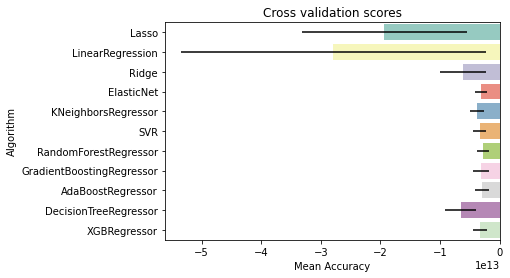

In [93]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [94]:
cv_res.sort_values(ascending=False, by='CrossValMeans')

,CrossValMeans,CrossValerrors,Algorithm
6,-2.826751e+12,1.016759e+12,RandomForestRegressor
8,-2.993639e+12,1.133094e+12,AdaBoostRegressor
3,-3.117271e+12,1.005355e+12,ElasticNet
7,-3.142418e+12,1.421736e+12,GradientBoostingRegressor
10,-3.333408e+12,1.225460e+12,XGBRegressor
5,-3.391994e+12,1.168265e+12,SVR
4,-3.781992e+12,1.170874e+12,KNeighborsRegressor
2,-6.132149e+12,3.885385e+12,Ridge
9,-6.529310e+12,2.627995e+12,DecisionTreeRegressor
0,-1.933407e+13,1.383082e+13,Lasso


In [95]:
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#import optuna
 
def objective(trial):
    params = {
        'alpha': trial.suggest_loguniform("alpha", 0.1, 5), 
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'normalize': trial.suggest_categorical('normalize', [True, False]),
    }
 
    reg = Ridge(**params)
    reg.fit(X_train, Y_train)
    y_pred = reg.predict(X_test)
 
    mae = mean_absolute_error(Y_test, y_pred)
    return mae

In [96]:
pip install optuna

In [97]:

import optuna
study = optuna.create_study()
study.optimize(objective, n_trials=100)

# 結果を表示
print(f'best score: {study.best_value:.4f}, best params: {study.best_params}')

[I 2021-03-01 13:53:33,212] A new study created in memory with name: no-name-eb27d2d3-43ad-4052-924d-4a00d763489c
[I 2021-03-01 13:53:33,232] Trial 0 finished with value: 2040414.6810245514 and parameters: {'alpha': 0.28858968831831466, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 2040414.6810245514.
[I 2021-03-01 13:53:33,243] Trial 1 finished with value: 1700957.1279109148 and parameters: {'alpha': 2.911528633081472, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 1700957.1279109148.
[I 2021-03-01 13:53:33,256] Trial 2 finished with value: 1511512.4459655562 and parameters: {'alpha': 0.10283723030094466, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 1511512.4459655562.
[I 2021-03-01 13:53:33,267] Trial 3 finished with value: 2135761.9862295478 and parameters: {'alpha': 0.15566622943774044, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 1511512.4459655562.
[I 2021-03-01 13:53:33,278] T

best score: 1270127.2556, best params: {'alpha': 3.6944423772545822, 'fit_intercept': True, 'normalize': True}


In [98]:
params = {'alpha': 4.358295477227332, 'fit_intercept': True, 'normalize': True}

reg = Ridge(**params)
reg.fit(X_train, Y_train)
prediction_log = reg.predict(test)
prediction =np.exp(prediction_log) 
print(prediction)

[inf inf inf ... inf inf inf]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

overflow encountered in exp



# Submit

In [51]:
#Submit方法
sub = pd.DataFrame(pd.read_csv('test.csv.zip')['Id'])
sub['Prediction'] = list(map(int, y_pred))
sub.to_csv('submission_yshimamu.csv', index=False)

NameError: ignored

In [ ]:
!kaggle competitions submit restaurant-revenue-prediction -f submission_yshimamu.csv -m "First commit"